In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../../libTLDA/

/atlas/u/kechoi/libTLDA


# Dataset

In [5]:
import torch
from sklearn.linear_model import LogisticRegression

In [6]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

In [7]:
from libtlda.iw import ImportanceWeightedClassifier

In [8]:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.7)
weights = kmm.iwe_kernel_mean_matching(X, Z)

     pcost       dcost       gap    pres   dres
 0:  3.4245e+04 -3.7060e+04  6e+06  1e+00  2e+00
 1:  6.9268e+04 -1.5210e+04  8e+05  1e-01  3e-01
 2:  7.9596e+04  1.6301e+04  1e+05  2e-02  4e-02
 3:  7.5137e+04  4.2916e+04  4e+04  4e-03  8e-03
 4:  6.9921e+04  5.8345e+04  1e+04  1e-04  3e-04
 5:  6.8026e+04  6.4756e+04  3e+03  5e-16  5e-13
 6:  6.7655e+04  6.6752e+04  9e+02  6e-17  5e-13
 7:  6.7556e+04  6.7375e+04  2e+02  6e-16  1e-12
 8:  6.7529e+04  6.7492e+04  4e+01  5e-16  4e-12
 9:  6.7524e+04  6.7516e+04  8e+00  9e-17  9e-12
10:  6.7522e+04  6.7521e+04  9e-01  4e-16  6e-11
11:  6.7522e+04  6.7522e+04  1e-01  5e-16  2e-10
12:  6.7522e+04  6.7522e+04  1e-02  6e-16  6e-10
Optimal solution found.


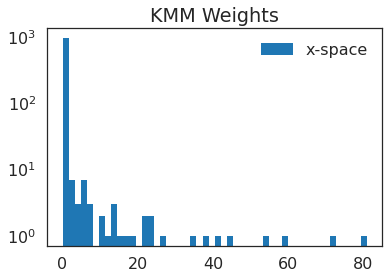

In [9]:
_ = plt.hist(weights, bins=50, label='x-space')
# _ = plt.hist(z_weights, bins=50, label='z-space')
plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

In [10]:
# Train via KLIEP
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error naive: 0.297
Error adapt: 0.259


In [11]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.247


What about the flow?

In [8]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [9]:
device = 'cuda'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
print(state['epoch'])

85


In [10]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

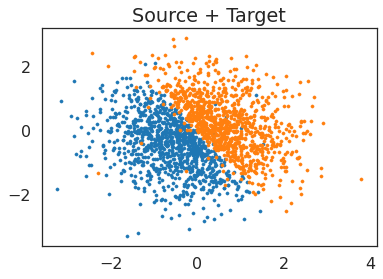

In [11]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cuda().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cuda().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

### train KMM on z

In [34]:
flow_x = flow_train_x.data.cpu().numpy()
flow_z = flow_test_x.data.cpu().numpy()

In [44]:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.1)
z_weights = kmm.iwe_kernel_mean_matching(flow_x, flow_z)

     pcost       dcost       gap    pres   dres
 0:  6.6780e+02 -3.2202e+04  3e+04  3e-17  3e+02
 1:  6.5183e+02 -2.9739e+03  4e+03  1e-16  3e+01
 2:  6.2499e+02  5.0027e+02  1e+02  1e-16  6e-15
 3:  6.2102e+02  6.1662e+02  4e+00  2e-16  3e-14
 4:  6.2090e+02  6.2064e+02  3e-01  5e-16  1e-13
 5:  6.2089e+02  6.2089e+02  4e-03  6e-16  5e-13
 6:  6.2089e+02  6.2089e+02  5e-05  9e-16  3e-12
Optimal solution found.


In [45]:
# Train via KMM
# from sklearn.linear_model import LogisticRegressionCV
# clf = LogisticRegressionCV(cv=5, solver='lbfgs')
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y, sample_weight=z_weights)
pred_adapt = clf.predict(Z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.311


In [46]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(Z_test)
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.298


Target
- Error naive: 0.297
- Error adapt: 0.259

Target (test)
- Error naive: 0.286
- Error adapt: 0.247

In [16]:
_ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

NameError: name 'weights' is not defined

---------

### What if I do the entire thing in z-space?

In [29]:
# Train via KMM
clf = LogisticRegression()
clf.fit(flow_x, y, sample_weight=z_weights)
pred_adapt = clf.predict(flow_z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.638


In [30]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.629


----

### naive LR in z-space

In [90]:
lr = LogisticRegression()
lr.fit(flow_x, y)
pred_naive = lr.predict(flow_z)

# Compute error rates
print('Error naive in z-space: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive in z-space: 0.635


In [91]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_naive_test = lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive (test) in z-space: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive (test) in z-space: 0.629


---

# Weights

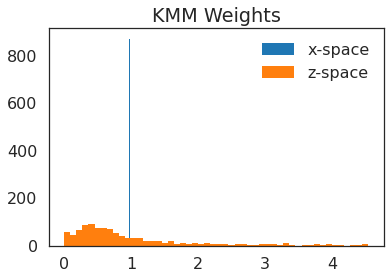

In [93]:
_ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()